In [143]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 8.632378 , 11.750549 ,  9.458651 ,  9.259321 ,  6.7811313,
        7.679055 , 10.168513 ,  8.56883  ,  7.7195454,  9.047131 ,
        9.511005 ,  7.727094 ], dtype=float32)

In [145]:
run_paths = glob.glob("/media/beans/ssd/blender_membank/*/run*", recursive=True)

In [146]:
run_path = random.choice(run_paths)
chunks_range = range(115, 1160, 116)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 100, 80, 3),
 '/media/beans/ssd/blender_membank/dataloader_09/run_20')

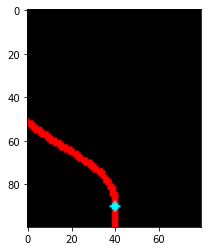

In [147]:
plt.imshow(maps[550])

In [148]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

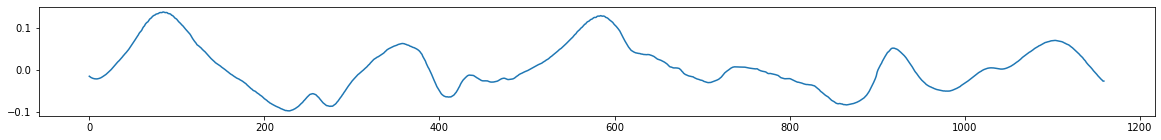

In [149]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

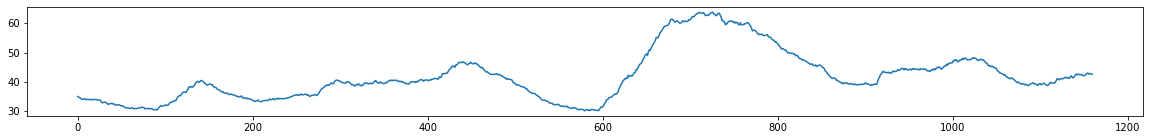

In [150]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [151]:
ix = 600

In [152]:
t = smooth_near_wps(targets[ix])

In [153]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [154]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

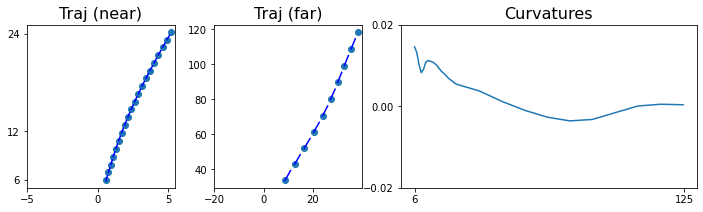

In [155]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

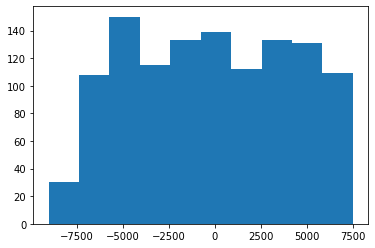

In [156]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

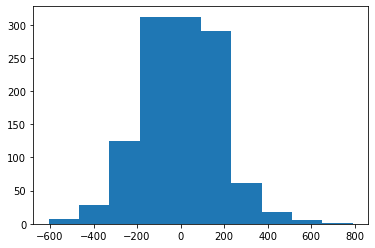

In [157]:
plt.hist(torque[1:]-torque[:-1])[2]

In [158]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [159]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-80:,:] = np.fliplr(maps[i])
    
    video.write(img)
    
video.release()

In [160]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-80:,:] = np.fliplr(maps[i])
imgs.shape, aux.shape

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "8.9_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [161]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

In [162]:
obsnet_outs.shape

(1160, 3)

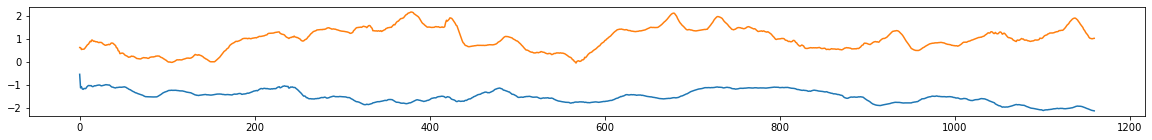

In [163]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [164]:
aux[0]

array([-1.5071025e+00,  6.1787933e-01,  3.4964561e+01,  0.0000000e+00,
       -3.0346576e-03], dtype=float32)

In [155]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/media/beans/ssd/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in range(115, 1160, 116)]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in range(115, 1160, 116)], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [137]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 6.78 s, sys: 0 ns, total: 6.78 s
Wall time: 6.79 s


In [138]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [139]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((347, 1160, 30), (347, 1160, 30), (347, 1160, 30), (347, 1160, 30))

<BarContainer object of 40 artists>

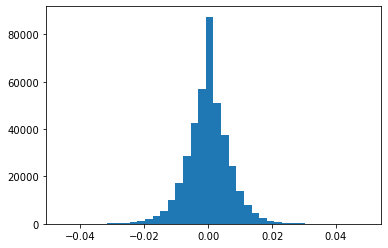

In [140]:
plt.hist(all_curvatures[:,:,2].flatten(), bins=40)[2]

In [141]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

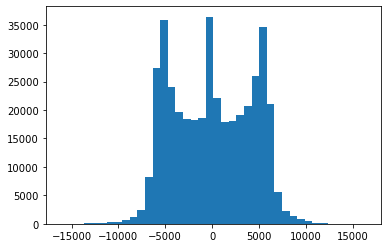

In [142]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

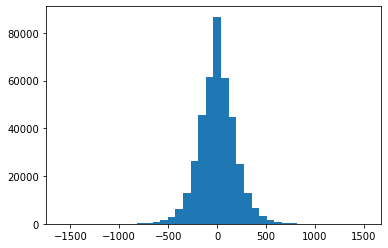

In [143]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [144]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(806.155777446054, 12005.917758190993)

In [145]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.9955826,   6.994812 ,   7.9939833,   8.993101 ,   9.992147 ,
        10.991108 ,  11.989968 ,  12.988734 ,  13.987382 ,  14.985882 ,
        15.984304 ,  16.982553 ,  17.980627 ,  18.978577 ,  19.976368 ,
        20.973885 ,  21.971336 ,  22.968542 ,  23.965586 ,  24.962395 ,
        34.91908  ,  44.85231  ,  54.76037  ,  64.641785 ,  74.497185 ,
        84.32797  ,  94.135765 , 103.9218   , 113.68669  , 123.43094  ],
      dtype=float32)

<BarContainer object of 40 artists>

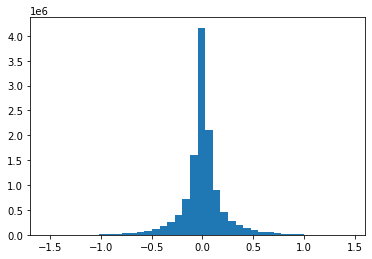

In [146]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [147]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02738494, 0.03168139, 0.03591783, 0.04015777, 0.04440023,
       0.04863898, 0.05287347, 0.05711115, 0.06135549, 0.06560324,
       0.06981723, 0.07398102, 0.07810591, 0.08216394, 0.08615208,
       0.09008061, 0.09397401, 0.09784701, 0.10168636, 0.1054083 ,
       0.14084215, 0.17366008, 0.20216231, 0.22625025, 0.24660711,
       0.2640384 , 0.27934295, 0.29269794, 0.3038847 , 0.30955687],
      dtype=float32)

In [148]:
mean_headings[-1] / mean_headings[0]

11.303907

In [149]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01851969, 0.02005163, 0.02173697, 0.02352041, 0.02537088,
       0.02726978, 0.02920313, 0.03116236, 0.03314144, 0.03513563,
       0.0371409 , 0.03915003, 0.04115805, 0.04316266, 0.04516321,
       0.04715692, 0.04914239, 0.05112118, 0.05309273, 0.05505542,
       0.07414249, 0.09211741, 0.10872184, 0.12375974, 0.13722637,
       0.14924294, 0.15997532, 0.16960397, 0.17824687, 0.18595272],
      dtype=float32)

In [150]:
mean_angles[-1] / mean_angles[0]

10.040811

In [151]:
mean_angles[0] / .015

1.2346461415290833

<BarContainer object of 40 artists>

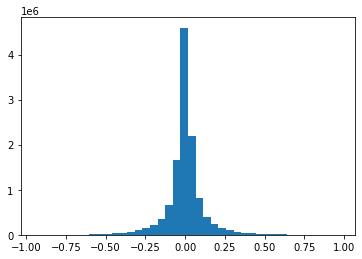

In [152]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

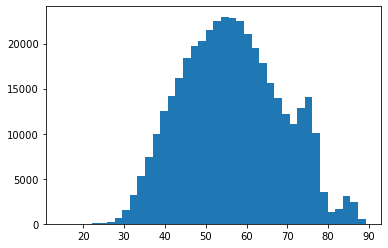

In [153]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

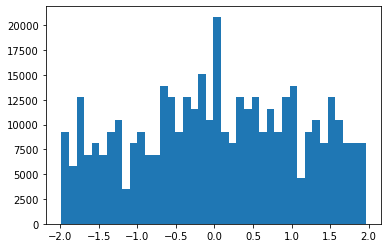

In [154]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

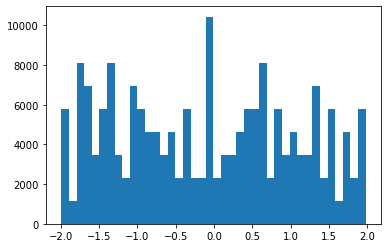

In [124]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]